<a href="https://colab.research.google.com/github/paddyz02/SR-Rnd/blob/main/Bayesian_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

Defining our Thinning Algorithm: Here, we take Ogata's (1981) thinning algorithm with 3 inputs, the horizon T, the base rate, and a  kernel. 

In [49]:
def Thinning_Sim(T, Base_Rate,Kernel=Blank_Kernel()):
    sample = np.array([]) # create empty array 
    t = np.zeros(1) # starting time
    while t[0]<T: # loop until you pass the observation horizon
        h0 = max(Base_Rate)+Kernel.bound(t,T,sample) # get upper bound
        u  = np.random.uniform(0,1,size=1) 
        t1  = -np.log(u)/h0 # generate random timestep
        t = min(T,t+t1) # make sure the timestep doesn't go too far (out of the observation horizon) 
        h1 = Base_Rate[int(t)-1]+Kernel.pulse(t,sample) # get intensity at new timestep
        s = np.random.uniform(0,1,size=1)[0]
        if s<=h1/h0: # randomly accept whether an event happened at this timestep
            sample = np.append(sample, t)
    return sample

For simplicity, we use an exponential kernel here.

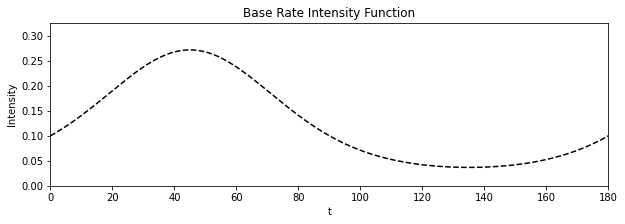

(sub)Sample data as a list of event times:
[ 1.3809221  22.86234383 23.53327235 26.10880146 31.77868225 34.98866673
 39.71160843 45.40139476 46.80436501 46.85336157]



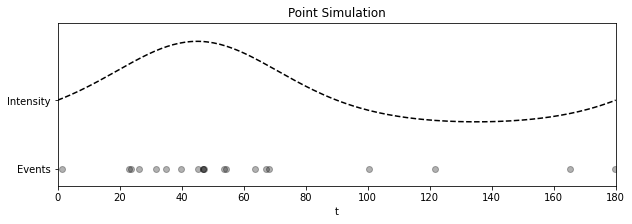

In [50]:
class Blank_Kernel:
    def __init__(self):
        return
    def bound(self,t,T,H):
        return np.zeros(1)
    def pulse(self,t,H):
        return np.zeros(1)
    
# set time horizon
horizon = np.array([180])

# build base rate function (really WHATEVER you want, it virtually has no restrictions)
timesteps = np.linspace(0, horizon[0], horizon[0])
base_rate = np.exp(np.sin(timesteps * (2 * math.pi)))/10

# get a good graph for that
fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=horizon)
ax.set_ylim(ymin=0,ymax=1.2*max(base_rate))
ax.plot(timesteps,base_rate,color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_ylabel("Intensity")
ax.set_title("Base Rate Intensity Function")
plt.show()

# simulate some points
simulated_sample = Thinning_Sim(horizon, base_rate)
print("(sub)Sample data as a list of event times:")
print(simulated_sample[:10])
print()

# plot those points againts the intensity function
fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=horizon)
ax.set_ylim(ymin=-0.15,ymax=1.2*(max(base_rate)))
ax.scatter(simulated_sample,np.zeros(len(simulated_sample))-0.1, color = "black", alpha=0.3)
ax.plot(timesteps,base_rate,color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_yticks([-0.1,base_rate[0]])
ax.set_yticklabels(["Events","Intensity"])
ax.set_title("Point Simulation")
plt.show()

Sampling from the multivariate normal prior:

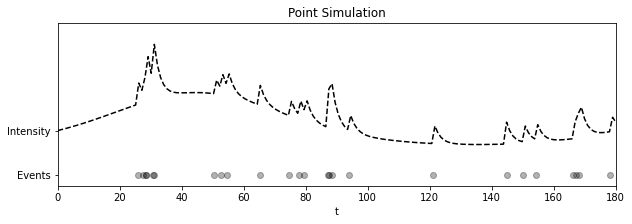

In [51]:
class Exp_Kernel:
    def __init__(self,params):
        self.α = params[0]
        self.β = params[1]
        
    def bound(self,t,T,H):
        grid = np.linspace(t[0],T[0],int(T[0]-t[0]+1)).reshape(-1,1) 
        deltas = grid - H.copy().reshape(1,-1).repeat(grid.shape[0],axis=0)
        raw = self.α*np.exp(-self.β*deltas)
        aggregate = np.sum((deltas>0)*raw,1)
        return max(aggregate)
    
    def pulse(self,t,H):
        t = t.copy().reshape(-1,1)
        deltas = t - H.copy().reshape(1,-1).repeat(t.shape[0],axis=0) 
        raw = self.α*np.exp(-self.β*deltas)
        aggregate = np.sum((deltas>0)*raw,1)
        return aggregate
    
params = [0.1, 0.5]
kernel = Exp_Kernel(params)
    
# simulate some points
simulated_sample = Thinning_Sim(horizon, base_rate, kernel)

# estimate intensity at each step:
total_intensity = base_rate + kernel.pulse(timesteps,simulated_sample)

# plot those points againts the intensity function
fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=horizon)
ax.set_ylim(ymin=-0.15,ymax=1.2*(max(total_intensity)))
ax.scatter(simulated_sample,np.zeros(len(simulated_sample))-0.1, color = "black", alpha=0.3)
ax.plot(timesteps,total_intensity,color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_yticks([-0.1,base_rate[0]])
ax.set_yticklabels(["Events","Intensity"])
ax.set_title("Point Simulation")
plt.show()


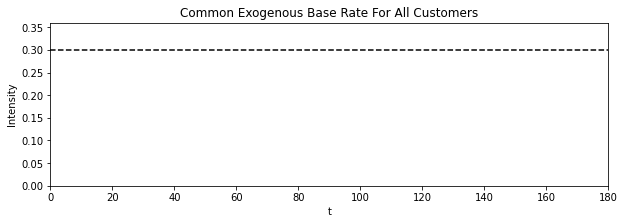

In [52]:
#base_rate1 = 0.3
base_rate_constant = 0.3* np.ones(len(timesteps))
base_rate_logn = np.exp(np.random.normal(np.log(0.3), 0.01, 500))
base_rate = np.ones(len(timesteps)).reshape(1, -1) * base_rate_logn.reshape(-1,1) # <- this is for each person 
#for k in range(1,len(base_rate1)):
#    base_rate1[k] += 0.2*base_rate1[k-1] 

fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=horizon)
ax.set_ylim(ymin=0,ymax=1.2*max(base_rate.mean(0)))
ax.plot(timesteps,base_rate.mean(0),color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_ylabel("Intensity")
ax.set_title("Common Exogenous Base Rate For All Customers")
plt.show()

hyperparams = [0.01,0.1,0.5,0.1]
horizon = np.array([180])
#Drawing the kernel 
alpha = np.random.beta(0.5, 0.5, 500)
beta = np.exp(np.random.normal(0, 0.01, 500))
alpha[alpha >= beta] = 0.8*beta[alpha >= beta]

dataset = pd.DataFrame(columns = ["ID","Params","Obs1"])
ID = []
d = dict()
d["global"] = hyperparams

#Simulating weibull (c = 1) death time with lambda = 120 
death = np.random.exponential(120, size = 500)
death = np.around(death)
for i in range(len(death)): 
  if death[i] > 180: 
    death[i] = 180

for i in range(500):
    kernel = Exp_Kernel([alpha[i], beta[i]])
    simulated_sample1 = Thinning_Sim(horizon, base_rate[i,:], kernel)
    d[i] = {}
    d[i]["params"] = [alpha[i], beta[i], base_rate[i]]
    d[i]['data'] = simulated_sample1


In [43]:
base_rate.shape

(500, 180)

In [16]:
dataset

,ID,Params,Obs1,Obs2,Obs3
0,0,"[0.010095112485540094, 0.57888657501034]","[8.199640286436761, 10.943202045130086, 11.127...","[0.03545519006911833, 0.23637824579749797, 0.4...","[0.7241149785957604, 0.8889777609312982, 1.504..."
0,1,"[0.00941804987117977, 0.5180622543396974]","[0.4416123836254378, 3.2014228556787296, 3.297...","[0.7203186500123763, 0.9356511571607308, 1.016...","[5.531508664269648, 14.35143632923999, 17.9158..."
0,2,"[0.010597942628168162, 0.537568292260389]","[1.2000841940133418, 5.398260475716273, 8.0120...","[0.36975803398394885, 0.4876780658151578, 0.80...","[1.2778007856853786, 1.6768227358615575, 6.066..."
0,3,"[0.008643824783599471, 0.526140730428148]","[0.24061067196154917, 0.37644370950873707, 2.8...","[0.177342187310168, 0.40562205695712095, 0.455...","[0.501819341836955, 1.738903405728184, 1.85517..."
0,4,"[0.009897251464570775, 0.48349321203023465]","[2.8610581911830457, 7.628103695968744, 8.7406...","[0.17573629746556224, 0.630009245221404, 0.992...","[0.2631751074693025, 0.37936185375895676, 1.86..."
...,...,...,...,...,...
0,495,"[0.011841959963364778, 0.5605469783341114]","[0.19885928350589718, 1.9853573742688675, 4.15...","[0.2689854772337288, 0.6695714175769714, 0.680...","[0.14753390387609183, 1.2370196657174717, 11.2..."
0,496,"[0.011663401110027727, 0.5101416467352566]","[8.169347241529653, 8.98575485200197, 11.90139...","[0.0015412908067590338, 0.22145207634124367, 0...","[1.2367685864507352, 9.196354418976924, 11.238..."
0,497,"[0.010264694219983142, 0.6526755427778311]","[0.03615702463831523, 1.128976438167647, 3.186...","[0.058547754847326536, 0.30464891181812537, 0....","[0.19183376976996402, 0.7162092894178478, 2.83..."
0,498,"[0.010132522078947276, 0.4372530758049504]","[0.3248114684860674, 7.392444104236322, 11.614...","[0.10182393053977525, 0.10499606854580257, 0.3...","[0.1440718600450551, 0.34357275777459473, 1.71..."


In [28]:


#pop truncates an array! Once the thing finishes running, pass in simulated
#samples and apply pop 


array([ 33., 155., 180.,  87.,  21.,  68.,  93., 180.,  65., 180.,  41.,
        70., 119.,  94.,  68.,  82., 162.,   0.,  15., 128., 180., 117.,
       180.,  97.,  17.,  37., 118., 180., 175., 174., 180.,  54., 180.,
        12.,  20.,  71.,  57., 180., 180., 106., 170., 168.,  61., 104.,
       180.,  76.,  85.,  33.,  40., 180., 180.,  51., 180., 166., 112.,
       180.,   4., 180., 180.,  33.,  46., 106.,  67.,   1., 180.,  12.,
        96.,  75., 136., 180., 160., 114.,  32., 105.,  14., 180.,  10.,
        21.,  44.,  48., 180.,  18., 115.,  23., 149.,   5.,  29., 180.,
         5.,  43.,  13.,  95.,   2.,  47., 101.,  18., 102., 133.,  15.,
        78.,   4., 180., 151.,  40.,  62.,  83., 152.,  62.,  80., 104.,
        91., 180.,  27., 149., 180.,  71., 180.,  32., 119.,  48.,  40.,
       103., 174.,  38., 180.,  99.,  63.,   1., 103., 125.,  89., 101.,
       155.,   8.,  20., 180.,  70.,  56., 133., 180.,  15.,  43., 114.,
        89., 180.,  13.,  56., 162.,  32., 148.,   

In [ ]:

for i in range(500):
  dataset["Obs_1"][i] = [ elem for elem in dataset['Obs_1'][i] if elem <= death[i]]
 